In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss
import pandas as pd
from torch import optim
import re
import json
import cv2
import types

In [3]:
from utils import *

In [4]:
import fastai
from fastprogress import force_console_behavior
import fastprogress
fastprogress.fastprogress.NO_BAR = True
master_bar, progress_bar = force_console_behavior()
fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

In [5]:
j = json.load(open('../data/annotations.json'))

In [6]:
j[0]['annotations'][0]

{'class': 'fluke',
 'height': 372.0,
 'type': 'rect',
 'width': 1017.0,
 'x': 14.0,
 'y': 97.0}

In [7]:
SZ = 224
BS = 64
NUM_WORKERS = 16

In [8]:
def anno2bbox(anno):
    im_width, im_height = PIL.Image.open(f"../data/train/{anno['filename']}").size
    anno = list(filter(lambda a: a['class'] == 'fluke', anno['annotations']))[0]
    return [
        np.clip(anno['y'], 0, im_height) / im_height * SZ,
        np.clip(anno['x'], 0, im_width) / im_width * SZ,
        np.clip(anno['y']+anno['height'], 0, im_height) / im_height * SZ,
        np.clip(anno['x']+anno['width'], 0, im_width) / im_width * SZ
    ]

In [9]:
fn2bbox = {jj['filename']: [[anno2bbox(jj)], ['fluke']] for jj in j}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)
get_y_func = lambda o: fn2bbox[path2fn(o)]

In [10]:
val_fns = pd.read_pickle('../data/val_fns_detection.pkl') # I create this file in fluke_detection.ipynb

In [11]:
class StubbedObjectCategoryList(ObjectCategoryList):
    def analyze_pred(self, pred): return [pred.unsqueeze(0), torch.ones(1).long()]

In [15]:
data = (ObjectItemList.from_df(pd.DataFrame(data=list(fn2bbox.keys())), path='../data/train-224')
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)                         
        .label_from_func(get_y_func, label_cls=StubbedObjectCategoryList)
        .transform(get_transforms(max_zoom=1, max_warp=0.05, max_rotate=0.05, max_lighting=0.2), tfm_y=True, size=(SZ,SZ), resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS)
        .normalize(imagenet_stats))

In [16]:
data.valid_ds.items

array(['../data/train-224/0dcfd05bf.jpg', '../data/train-224/fe576c02a.jpg', '../data/train-224/c30634691.jpg',
       '../data/train-224/f6218e09a.jpg', ..., '../data/train-224/37910314d.jpg', '../data/train-224/74996cbcc.jpg',
       '../data/train-224/e36654163.jpg', '../data/train-224/20601c5bf.jpg'], dtype='<U32')

In [17]:
batch = next(iter(data.valid_dl))

In [18]:
batch[0][0][1]

tensor([[1.9909, 1.9559, 1.9384,  ..., 1.9034, 1.9209, 1.9559],
        [1.8333, 1.8508, 1.9034,  ..., 1.8683, 1.9034, 1.9734],
        [1.6408, 1.7458, 1.8683,  ..., 1.7283, 1.8158, 1.9384],
        ...,
        [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
        [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
        [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
       device='cuda:0')

In [19]:
data.valid_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f9280270978>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7f928cd84d90>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=False)], collate_fn=<function data_collate at 0x7f929414f7b8>)

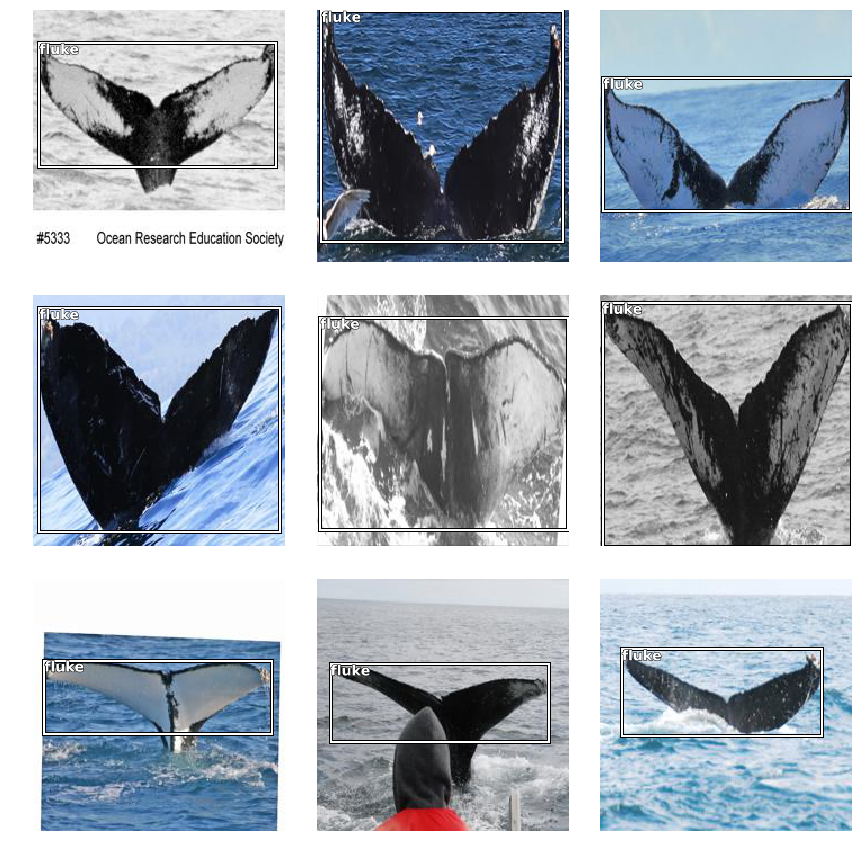

In [20]:
data.show_batch(rows=3, ds_type=DatasetType.Valid, figsize=(12,12))

In [21]:
class FlukeDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5)

In [22]:
def loss_fn(preds, targs, class_idxs):
    return L1Loss()(preds, targs.squeeze())

In [23]:
learn = Learner(data, FlukeDetector(arch=models.resnet50), loss_func=loss_fn)
learn.metrics = [lambda preds, targs, _: IoU(preds, targs.squeeze()).mean()]

In [24]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [25]:
learn.freeze_to(-1)

In [26]:
%time learn.fit_one_cycle(25, 1e-2, div_factor=12, pct_start=0.2)

epoch     train_loss  valid_loss  <lambda>
1         0.764614    0.779105    0.002934  
2         0.696593    0.544781    0.230923  
3         0.514927    0.129541    0.701927  
4         0.373916    0.114000    0.724241  
5         0.287710    0.087917    0.765200  
6         0.230763    0.081531    0.786741  
7         0.190886    0.079040    0.780568  
8         0.160731    0.093824    0.750857  
9         0.139407    0.094784    0.669360  
10        0.122565    0.079133    0.761410  
11        0.108539    0.054714    0.841223  
12        0.096573    0.051993    0.845985  
13        0.087745    0.053139    0.836615  
14        0.080579    0.048244    0.857626  
15        0.074886    0.052804    0.842158  
16        0.069478    0.045514    0.865042  
17        0.065024    0.045164    0.867401  
18        0.061063    0.043679    0.870720  
19        0.057192    0.043114    0.873035  
20        0.054608    0.041338    0.876477  
21        0.052194    0.040655    0.879656  
22        0.

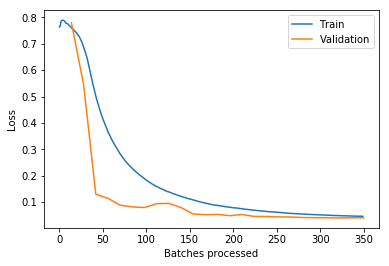

In [27]:
learn.recorder.plot_losses()

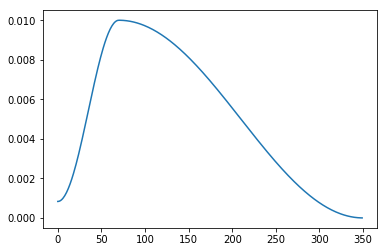

In [28]:
learn.recorder.plot_lr()

In [29]:
learn.unfreeze()

In [ ]:
max_lr = 1e-3
lrs = np.array([max_lr/100, max_lr/10, max_lr])

In [ ]:
%time learn.fit_one_cycle(120, lrs)

epoch     train_loss  valid_loss  <lambda>
1         0.045730    0.039661    0.883696  
2         0.045582    0.040389    0.879940  
3         0.043199    0.039654    0.882927  
4         0.042897    0.039002    0.886327  
5         0.042702    0.038577    0.887630  
6         0.042243    0.038638    0.886938  
7         0.042418    0.038510    0.886760  
8         0.042109    0.037402    0.889452  
9         0.041798    0.037462    0.889719  
10        0.041169    0.038816    0.886487  
11        0.041139    0.040767    0.880593  
12        0.040786    0.039552    0.883767  
13        0.040535    0.040023    0.882513  
14        0.040411    0.039939    0.880969  
15        0.040754    0.039111    0.883834  
16        0.041002    0.040390    0.882424  
17        0.040954    0.037872    0.885430  
18        0.040749    0.039080    0.882539  
19        0.040446    0.038646    0.885390  
20        0.040610    0.039591    0.883716  
21        0.040394    0.036060    0.894673  
22        0.

In [ ]:
learn.save('fluke_detector')

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.show_results(rows=6)